In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
from dpeva.uncertain.rnd import RandomNetworkDistillation

Initializing DP-EVA version 0.1.0


## Load descriptor example, 

descriptor shape : (nframe, ndim)

In [ ]:
all_desc_stru = np.load('../data/desc.npy')
all_desc_stru.shape

(20873, 136)

## Random Network Distillation

The Random Network Distillation (RND) is a method to learn the representation of the environment and calculate the intrinsic reward of the target data. The idea is to train a neural network to predict the output of a fixed randomly initialized neural network. The fixed network is used to generate the target, and the trainable network is used to predict the target. The intrinsic reward is calculated by the difference between the target and the prediction which is used to train the agent to explore the environment. 

Here in MLIP active learning ,the 'agnet' is our MLIP and the environment is the atomistic space.

In [4]:
# randomly choose 80% of the data as training data
np.random.seed(19090)
train_index = np.random.choice(range(len(all_desc_stru)), int(0.8*len(all_desc_stru)), replace=False)
desc = all_desc_stru[train_index]
desc.shape

(16698, 136)

In [5]:
%%time
# parameters, can be tuned
input_dim = desc.shape[-1]  # input dimension
output_dim = 240  # output dimension
hidden_dim = 240  # hidden dimension
num_residual_blocks = 1  # number of residual blocks
device = "cpu"  # device

# initialization
rnd = RandomNetworkDistillation(
            input_dim=input_dim, 
            output_dim=input_dim, 
            hidden_dim=hidden_dim, 
            num_residual_blocks=num_residual_blocks, 
            distance_metric="cossim", 
            device=device)

# fit the predictor network
rnd.train(desc, 
          num_batches=4000,
          batch_size=2048,
          initial_lr=1e-3,
          gamma=0.98,
          decay_steps=20,
          disp_freq=200,
          save_freq=1000)

2025-01-11 15:55:54,153 - INFO - Target network saved to ./models/target_network.pth
2025-01-11 15:55:58,037 - INFO - Batch 200/4000 completed, Time: 3.88s, Avg Loss: 0.020814
2025-01-11 15:56:01,595 - INFO - Batch 400/4000 completed, Time: 3.56s, Avg Loss: 0.001470
2025-01-11 15:56:05,105 - INFO - Batch 600/4000 completed, Time: 3.51s, Avg Loss: 0.000959
2025-01-11 15:56:08,715 - INFO - Batch 800/4000 completed, Time: 3.61s, Avg Loss: 0.000758
2025-01-11 15:56:12,326 - INFO - Batch 1000/4000 completed, Time: 3.61s, Avg Loss: 0.000650
2025-01-11 15:56:12,330 - INFO - Predictor network saved to ./models/predictor_network_batch_1000.pth
2025-01-11 15:56:16,298 - INFO - Batch 1200/4000 completed, Time: 3.97s, Avg Loss: 0.000587
2025-01-11 15:56:19,810 - INFO - Batch 1400/4000 completed, Time: 3.51s, Avg Loss: 0.000541
2025-01-11 15:56:23,244 - INFO - Batch 1600/4000 completed, Time: 3.43s, Avg Loss: 0.000508
2025-01-11 15:56:26,637 - INFO - Batch 1800/4000 completed, Time: 3.39s, Avg Loss

CPU times: user 18min 32s, sys: 27.6 s, total: 19min
Wall time: 1min 12s


After training for predictor network, we can use the distance between target network and predictor network as the intrinsic reward for data to be sampled

In [6]:
%%time
intrinsic_rewards = []
batch_size = 4096 

# transform intrinsic_rewards to numpy array
intrinsic_rewards = rnd.eval_intrinsic_rewards(all_desc_stru, batch_size=batch_size)

2025-01-11 15:57:05,428 - INFO - Calculating intrinsic rewards for size 20873 with batch size 4096
2025-01-11 15:57:05,429 - INFO - Calculating intrinsic rewards for batch 1/6
2025-01-11 15:57:06,847 - INFO - Calculating intrinsic rewards for batch 2/6
2025-01-11 15:57:08,273 - INFO - Batch 2/6 completed, Time: 2.84s, 
2025-01-11 15:57:08,274 - INFO - Calculating intrinsic rewards for batch 3/6
2025-01-11 15:57:09,698 - INFO - Calculating intrinsic rewards for batch 4/6
2025-01-11 15:57:11,153 - INFO - Batch 4/6 completed, Time: 2.88s, 
2025-01-11 15:57:11,153 - INFO - Calculating intrinsic rewards for batch 5/6
2025-01-11 15:57:12,587 - INFO - Calculating intrinsic rewards for batch 6/6
2025-01-11 15:57:12,724 - INFO - Batch 6/6 completed, Time: 1.57s, 
2025-01-11 15:57:12,725 - INFO - Intrinsic rewards calculation done


CPU times: user 7.3 s, sys: 269 μs, total: 7.3 s
Wall time: 7.3 s


In [7]:
# top 200 unique points
top_50_indices = np.argsort(intrinsic_rewards)[-50:]  
top_50_points = all_desc_stru[top_50_indices]  

print("Indices of Top 200 points with highest intrinsic rewards:", top_50_indices)

Indices of Top 200 points with highest intrinsic rewards: [ 7969 16561  3613   734 14751   723  7263  1241   732  8060 18307 12469
  8067  7986 12464 14712 18889 10815  8054 13027 18342 12466 16049 20751
 10367 12952 18848   110  3599 17444  3556 13058 15273 18294 18840 18805
 12453 18806 18807 10805  4210 20750  7520 18101 10101  7382  1288  4224
  4225 11636]


## Visualizing the uncertainty (reward) results

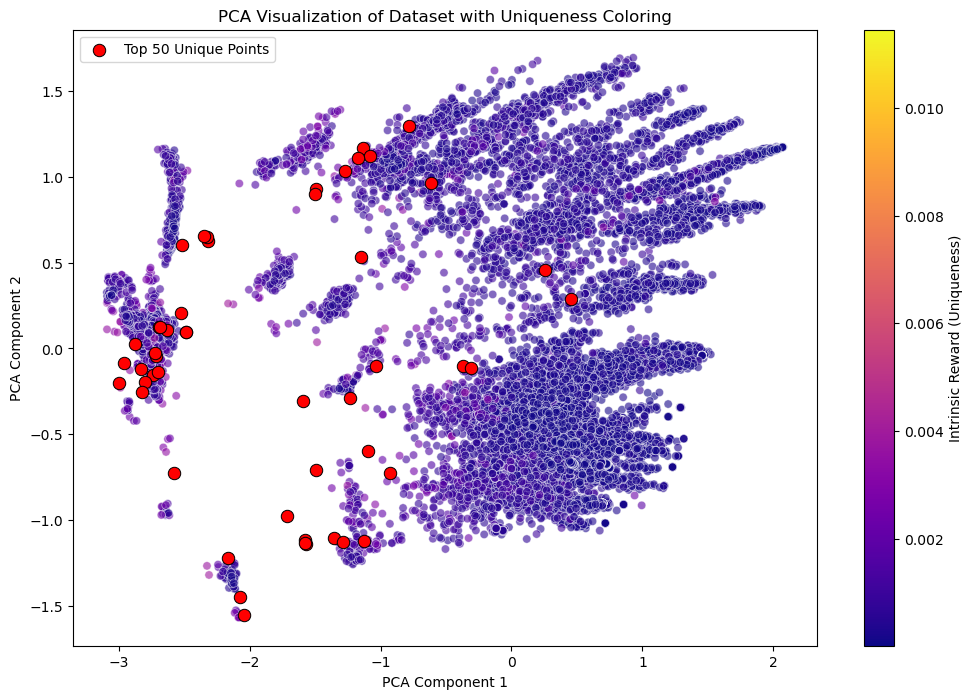

In [8]:
# PCA reduction
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(all_desc_stru) 
top_50_pca_result = pca.transform(top_50_points) # PCA reduction for top 200 unique points in the same space

plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

sns.scatterplot(
    x=top_50_pca_result[:, 0], y=top_50_pca_result[:, 1],
    color="red", label="Top 50 Unique Points", s=80, edgecolor="black"
)

norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

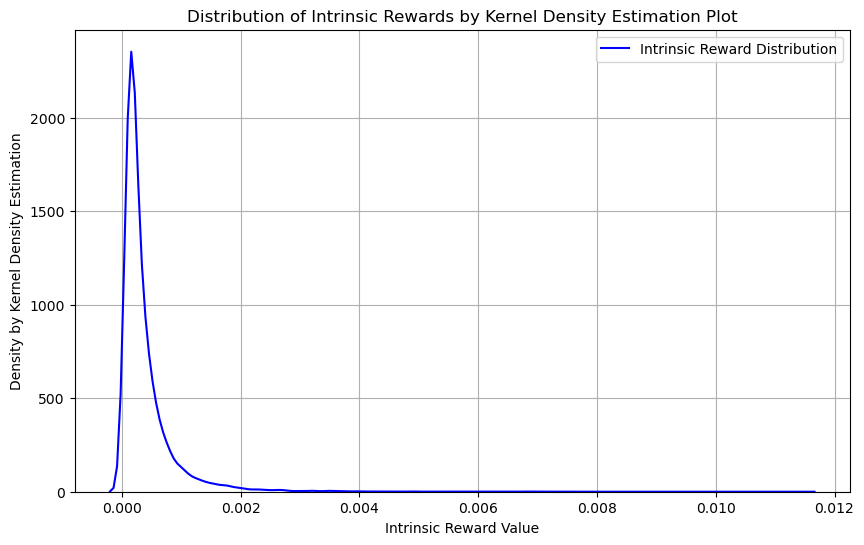

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 
plt.title("Distribution of Intrinsic Rewards by Kernel Density Estimation Plot")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density by Kernel Density Estimation")
plt.legend()
plt.grid(True)
plt.show()

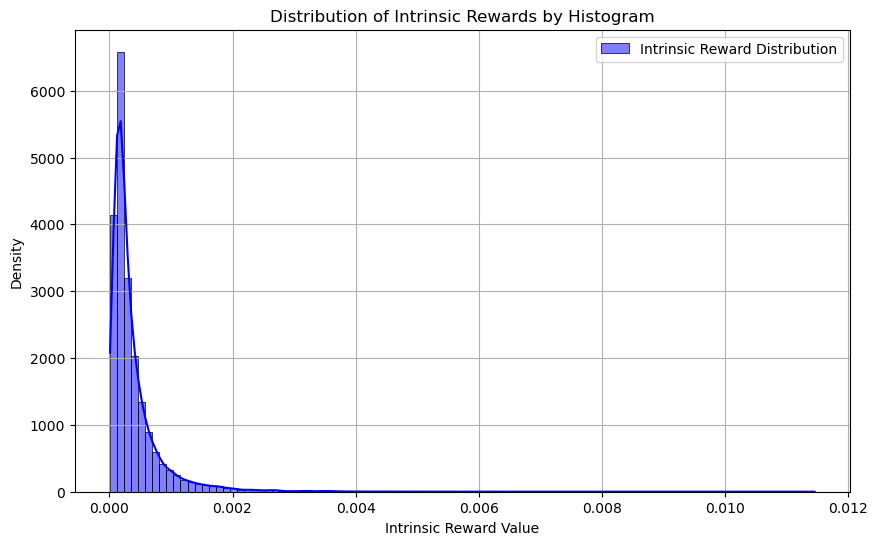

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=100, kde=True)
plt.title("Distribution of Intrinsic Rewards by Histogram")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()